In [153]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sps
from sklearn.manifold import MDS as MDS1
from sklearn.manifold import Isomap
from adjustText import adjust_text

### Preprocessing the data

In [154]:
# Importing the data into pandas dataframe
df = pd.read_csv('zoo.csv')

# Normalising the "legs" column to be same order of magnitude as the rest
max_value_legs = df["legs"].max()
df['legs'] = df['legs'].divide(max_value_legs)
df = df.transpose()

# Removing 'animal name' and 'type' since not used for PCA 
preprocessed_dataframe = df.drop(axis = 0, index = ['animal name', 'type'])
df = df.transpose()

# In data_matrix:
# Columns: Data points
# Rows: Attributes
data_matrix = preprocessed_dataframe.to_numpy(dtype=float)

### Implementation of PCA

In [155]:

def PCA(data_matrix):
    # Centering the data for PCA
    centered_data_matrix = data_matrix - np.reshape(np.mean(data_matrix, axis = 1), (16,1))

    [U,S,V] = np.linalg.svd(centered_data_matrix)
    W = U[:,0:2]

    # In embedding:
    # Columns: Data points
    # Rows: Attributes
    embedding = np.tensordot(W.T, centered_data_matrix, axes = 1)
    
    return embedding



### Implementation of MDS

In [156]:
def weighted_distance(a,b, weight_vector = np.ones(16)):
    attribute_weight_matrix = np.diag(weight_vector)
    weighted_difference = np.matmul(attribute_weight_matrix, a-b)

    return np.dot(a-b,weighted_difference)

def to_dist_matrix(data_matrix, weight_vector):
    distance_matrix = np.array([[weighted_distance(a, b, weight_vector) for a in data_matrix.T] for b in data_matrix.T])
    
    return distance_matrix

def dist_to_similarity_matrix(K):
    
    # Transforming it to a similarity matrix
    n = K.shape[1]
    sum_matrix = np.ones((n,n))
    mean_rows = np.matmul(K,sum_matrix)/n
    mean_columns = np.matmul(sum_matrix, K)/n
    variance = np.matmul(sum_matrix, mean_rows)/n

    similarity_matrix = -0.5*(K - mean_rows - mean_columns + variance)

    return similarity_matrix

def MDS(similarity_matrix, n_latent_variables):
    
    [D,Q] = np.linalg.eig(similarity_matrix)
    # Ensuring that the eigenvalues are real
    D = np.real(D)
    Q = np.real(Q)
    
    # Sorting the eigenpairs after magnitude of eigenvalues
    order = np.flip(np.argsort(D))
    D = D[order]
    Q = Q[:,order]
    D = np.diag(D)
    
    # Finding the latent variables
    I = np.eye(n_latent_variables, D.shape[0])
    placeholder = np.matmul(I, np.sqrt(np.abs(D)))
    embedding = np.matmul(placeholder, Q.T)
    
    return embedding



### Implementation of Isomap

In [157]:
def to_graph_matrix2(data_matrix, k_neighbours, weight_vector):
    """
    Computing the graph matrix of the data, connecting the k closest points
    :param data_matrix: Matrix of size (m,n) with data points as columns and attributes as rows
    :param k_neighbours: Number of connected neighbours in the resulting graph
    :return: graph matrix of size (n,n)
    """
    graph_matrix = to_dist_matrix(data_matrix, weight_vector)
    
    # Marking neighbours further away than "k_neighbours" as unobtainable
    neighbour_order = np.argsort(graph_matrix, axis=1)
    graph_matrix[neighbour_order > k_neighbours] = 0

    return graph_matrix

def to_graph_matrix(data_matrix, k_neighbours, weight_vector):
    """
    Computing the graph matrix of the data, connecting the k closest points
    :param data_matrix: Matrix of size (m,n) with data points as columns and attributes as rows
    :param k_neighbours: Number of connected neighbours in the resulting graph
    :return: graph matrix of size (n,n)
    """
    distance_matrix = to_dist_matrix(data_matrix, weight_vector)
    
    graph_matrix = np.zeros(distance_matrix.shape)
    for i in range(distance_matrix.shape[0]):
        # Marking neighbours further away than "k_neighbours" as unobtainable
        idx = np.argsort(distance_matrix[i,:])[1:k_neighbours]
        graph_matrix[i, idx] = distance_matrix[i,idx]

    return graph_matrix

def isomap(data_matrix, k, n_latent_variables, weight_vector):
    
    graph_matrix = to_graph_matrix(data_matrix, k, weight_vector)
    shortest_path_matrix = sps.csgraph.shortest_path(graph_matrix, directed=False)
    similarity_matrix = dist_to_similarity_matrix(shortest_path_matrix)
    embedding = MDS(similarity_matrix, n_latent_variables)

    return embedding


### Running the Implementations

In [158]:
#PCA
embedding_PCA = PCA(data_matrix)
# Adding the embedding to the original dataframe
df['x1_PCA'] = embedding_PCA[0,:].T
df['x2_PCA'] = embedding_PCA[1,:].T

# MDS
weight_vector = np.ones(16)
weight_vector[12] = 4
weight_vector[13] = 4
similarity_matrix = dist_to_similarity_matrix(to_dist_matrix(data_matrix, weight_vector))
embedding_MDS = MDS(similarity_matrix, 2)
# Adding the embedding to the original dataframe
df['x1_MDS'] = embedding_MDS[0,:]
df['x2_MDS'] = embedding_MDS[1,:]

# Isomap
weight_vector = np.ones(16)
number_of_neighbours = 30
embedding_isomap = isomap(data_matrix, number_of_neighbours, 2, weight_vector)
# Adding the embedding to the original dataframe
df['x1_isomap'] = embedding_isomap[0,:]
df['x2_isomap'] = embedding_isomap[1,:]

### Plotting the results

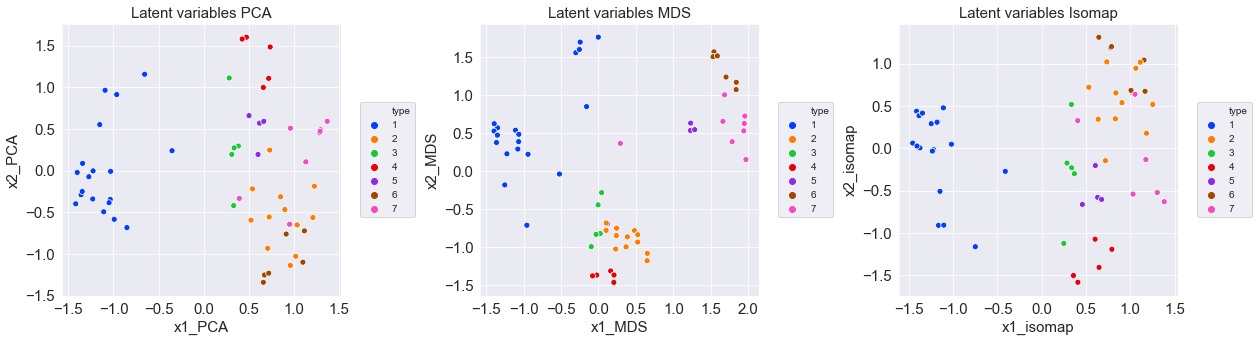

In [159]:
x1 = ['x1_PCA', 'x1_MDS', 'x1_isomap']
x2 = ['x2_PCA', 'x2_MDS', 'x2_isomap']
title = ['Embedding PCA', 'Embedding MDS', 'Embedding Isomap']



fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)
for i in range(3):
    ax = sns.scatterplot(ax=axes[i], x=x1[i], y=x2[i], hue='type', data=df, palette='bright')
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
    axes[i].set_title(title[i])
    sns.set_style('darkgrid')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)  

plt.savefig('Comparison_plot', dpi = 300)
plt.show()


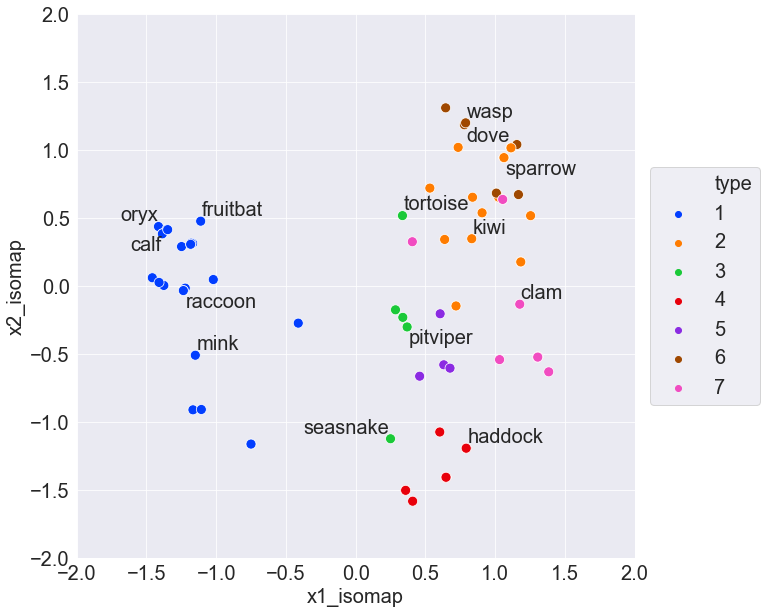

In [160]:
x1 = ['x1_PCA', 'x1_MDS', 'x1_isomap']
x2 = ['x2_PCA', 'x2_MDS', 'x2_isomap']
title = ['Visualization_PCA', 'Visualization_MDS', 'Visualization_Isomap']

method = 2

texts = []
indicator = np.array([0 if (x + 1) % 7 == 0 else 1 for x in range(101)])
names = np.asarray(df['animal name'].copy())
names[indicator==1] = ''

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
plt.subplots_adjust(wspace=0.5)
ax = sns.scatterplot(ax=axes, x=x1[method], y=x2[method], hue='type', data=df, palette='bright', s=100)
for x, y, t in zip(df[x1[method]], df[x2[method]], names):
    texts.append(axes.text(x, y, t, fontsize=20))
    
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, fontsize=20)
#axes.set_title(title[method])
sns.set_style('darkgrid')
plt.ylim([-2,2])
plt.xlim([-2,2])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)  
adjust_text(texts, force_points=0.15)

plt.savefig(title[method], dpi=300,bbox_inches='tight', pad_inches=1)
plt.show()


In [161]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

    animal name hair feathers eggs milk airborne aquatic predator toothed  \
0      aardvark    1        0    0    1        0       0        1       1   
1      antelope    1        0    0    1        0       0        0       1   
2          bass    0        0    1    0        0       1        1       1   
3          bear    1        0    0    1        0       0        1       1   
4          boar    1        0    0    1        0       0        1       1   
5       buffalo    1        0    0    1        0       0        0       1   
6          calf    1        0    0    1        0       0        0       1   
7          carp    0        0    1    0        0       1        0       1   
8       catfish    0        0    1    0        0       1        1       1   
9          cavy    1        0    0    1        0       0        0       1   
10      cheetah    1        0    0    1        0       0        1       1   
11      chicken    0        1    1    0        1       0        0       0   